In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from tqdm import tqdm
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from datetime import datetime
from torchvision import models
#from transformers import CLIPProcessor, CLIPModel
import os
import csv
from peft import LoraConfig, get_peft_model
import json

import pandas as pd
import os
import random
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json

import transformers
from transformers import CLIPProcessor, CLIPModel
from multilingual_clip import pt_multilingual_clip # Note: add device parameter to forward manually
import open_clip

import psycopg2

from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [104]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")
RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")
WRITTEN_CAPTIONS_TESTING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TESTING_SET")
WRITTEN_CAPTIONS_VALIDATION_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_VALIDATION_SET")
FILE_FABRITIUS_ICONOGRAPHIES_JSON = PARENT + os.getenv("FILE_FABRITIUS_ICONOGRAPHIES_JSON")
EMBEDDINGS_FOLDER = PARENT + os.getenv("EMBEDDINGS_FOLDER")
MODELS_FOLDER = PARENT + os.getenv("MODELS_FOLDER")

DB_INPUT_ARTPIECES = PARENT + os.getenv("DB_INPUT_ARTPIECES")
DB_INPUT_ARTISTS = PARENT + os.getenv("DB_INPUT_ARTISTS")
DB_INPUT_SUBJECTMATTER = PARENT + os.getenv("DB_INPUT_SUBJECTMATTER")

FILE_SUBJECTMATTERS_PARSED = PARENT + os.getenv("FILE_SUBJECTMATTERS_PARSED")

def get_db_config():
    return {
        "host": os.getenv("DB_HOST"),
        "port": os.getenv("DB_PORT"),
        "name": os.getenv("DB_NAME"),
        "user": os.getenv("DB_USER"),
        "password": os.getenv("DB_PASSWORD"),
    }

##

def fixPath(path):
    return path.replace(".././", "../")

In [5]:
# Query the DB for all the recordIDs of the table Artwork
def get_image_data_from_db(db_config):
    conn = None
    try:
        conn = psycopg2.connect(
            host=db_config["host"],
            port=db_config["port"],
            database=db_config["name"],
            user=db_config["user"],
            password=db_config["password"]
        )
        cur = conn.cursor()
        cur.execute(f"SELECT recordID, imageLowResFilename FROM Artwork")
        data = cur.fetchall()
        cur.close()
        return data
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()

DATA = get_image_data_from_db(get_db_config())
DATA[:5]

[(64, '/art-foto/old/internet/Bouts-8181dig-L.jpg'),
 (77, '/art-foto/mod/Internet/deSmet-11120dig-L.jpg'),
 (78, '/art-foto/mod/Internet/Khnopff-3980dig-L.jpg'),
 (79, '/art-foto/mod/Internet/Khnopff-6366dig-L.jpg'),
 (80, '/art-foto/mod/Internet/Khnopff-6768dig-L.jpg')]

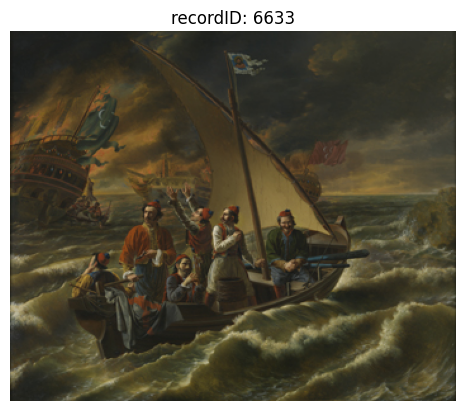

In [6]:
# Show a random image
def getImagePath(image_path):
    return fixPath(os.path.join(IMAGES_FOLDER, image_path[1:]))

recordID, image_path = random.choice(DATA)
image = Image.open(getImagePath(image_path))
plt.imshow(image, cmap="gray")
plt.title(f"recordID: {recordID}")
plt.axis("off")
plt.show()

In [136]:
model_name_db = "february_finetuned"
model_name_db = "art-base"
model_name_db = "art-mini"

base_name = os.getenv(f"{model_name_db}_model_name")
path_embeddings = PARENT + os.getenv(f"{model_name_db}_path_embeddings")
path_index_to_recordID = PARENT + os.getenv(f"{model_name_db}_path_index_to_recordID")

paths_keywords_embeddings = {}
paths_keywords_term_data = {}
for lang in ["fr", "en", "nl"]:
    paths_keywords_embeddings[lang] = PARENT + os.getenv(f"{model_name_db}_path_keywords_embeddings_{lang}")
    paths_keywords_term_data[lang] = PARENT + os.getenv(f"{model_name_db}_path_keywords_term_data_{lang}")

In [137]:
processor = CLIPProcessor.from_pretrained(base_name)
model = CLIPModel.from_pretrained(base_name).to(device)
tokenizer = transformers.AutoTokenizer.from_pretrained(base_name)
# Load the weights of the model
weights_path = PARENT + os.getenv(f"{model_name_db}_weights_path")
# Load the weights of the model
model.load_state_dict(torch.load(weights_path))

C:\Users\victo\AppData\Local\Temp\ipykernel_23412\3559517024.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path))


<All keys matched successfully>

In [138]:
class ComputeEmbeddingsDataset(Dataset):
    def __init__(self, data, getImagePath):
        self.data = data
        self.getImagePath = getImagePath

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        _, image_path = self.data[idx]
        path = self.getImagePath(image_path)
        path = path.replace("internet", "Internet")
        path = path.replace("Mod", "mod")
        path = path.replace("Old", "old")
        path = path.replace("Stefaan", "stefaan")
        path = path.replace("Art-Foto", "art-foto")
        image = Image.open(path)

        return image
    
def customBatchBuilder(images):
    inputs = processor(text=[""] * len(images), images=images, return_tensors="pt", padding=True, truncation=True)
    return inputs

dataset = ComputeEmbeddingsDataset(DATA, getImagePath)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=customBatchBuilder)
print(len(dataset), len(dataloader))

5301 5301


In [139]:
path_embeddings

'./../.././private_data/embeddings/art-mini/art-mini_embeddings.npy'

In [140]:
# Create the folders if they don't exist
os.makedirs(PARENT + os.getenv("EMBEDDINGS_FOLDER") + model_name_db, exist_ok=True)

In [141]:
def compute_embeddings(dataloader, model, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for sample in tqdm(dataloader):
            input_ids = sample['input_ids'].to(device)
            attention_mask = sample['attention_mask'].to(device)
            pixel_values = sample['pixel_values'].to(device)

            # Compute image embeddings
            image_features = model.get_image_features(pixel_values=pixel_values)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.flatten(1)

            embeddings.append(image_features)

    embeddings = torch.cat(embeddings, dim=0)
    embeddings = embeddings.cpu().numpy()
    return embeddings

images_embeddings = compute_embeddings(dataloader, model, device)
# Save the embeddings
np.save(path_embeddings, images_embeddings)
images_embeddings.shape

100%|██████████| 5301/5301 [01:09<00:00, 76.52it/s]


(5301, 512)

In [142]:
index_to_recordID = {}
for i, (recordID, _) in enumerate(DATA):
    index_to_recordID[i] = recordID

with open(path_index_to_recordID, "w") as f:
    json.dump(index_to_recordID, f)

In [143]:
subjectmatter_json = json.loads(open(FILE_SUBJECTMATTERS_PARSED, "r", encoding="utf-8").read())
len(subjectmatter_json)

5301

In [144]:
all_subjectmatter_terms = []
for subjectmatter in tqdm(subjectmatter_json):
    all_subjectmatter_terms += subjectmatter["structured"]["subjectMatterSubjectTerms"]["flattened"]
len(all_subjectmatter_terms)

100%|██████████| 5301/5301 [00:00<00:00, 1060580.30it/s]


30849

In [145]:
# Get the most common subject matter terms
from collections import Counter

subjectmatter_counter = Counter(all_subjectmatter_terms)
_50_most_common_subjectmatter = subjectmatter_counter.most_common(50)
_50_most_common_subjectmatter = [term for term, count in _50_most_common_subjectmatter]
_50_most_common_subjectmatter[:5]

['homme', 'figure', 'femme', 'groupe de figures', 'animal']

In [146]:
keywords = {
    'en': {
        'animal': {
            'synonyms': ['beast',
                'creature',
                'specimen',
                'non-human living being',
                'non-human organism'
            ],
            'type': 'keyword'
        },
        'architecture': {
            'synonyms': ['building',
                'construction',
                'structure',
                'edifice',
                'monument'
            ],
            'type': 'keyword'
        },
        'beard': {
            'synonyms': ['male facial hair',
                'facial hair',
                'goatee',
                'beard',
                'moss'
            ],
            'type': 'keyword'
        },
        'bird': {
            'synonyms': ['plumed animal',
                'volatile',
                'plumage',
                'raptor',
                'bird'
            ],
            'type': 'keyword'
        },
        'black and white': {
            'synonyms': ['monochrome',
                'without color',
                'n&b',
                'black and white'
            ],
            'type': 'color'
        },
        'blue hue': {
            'synonyms': ['blue',
                'blue hue',
                'bluish tint',
                'blue color'
            ],
            'type': 'color'
        },
        'boat': {
            'synonyms': ['ship', 'boat', 'sailboat', 'liner', 'skiff'],
            'type': 'keyword'
        },
        'book': {
            'synonyms': ['printed work',
                'manual',
                'written document',
                'publication',
                'book'
            ],
            'type': 'keyword'
        },
        'bright colors': {
            'synonyms': ['bright colors',
                'vivid hues',
                'intense colors',
                'bright shades'
            ],
            'type': 'color'
        },
        'bright image': {
            'synonyms': ['bright image',
                'illuminated image',
                'shiny image',
                'luminous image'
            ],
            'type': 'luminosity'
        },
        'building': {
            'synonyms': ['edifice',
                'construction',
                'structure',
                'building',
                'architecture'
            ],
            'type': 'keyword'
        },
        'bust': {
            'synonyms': ['bust portrait',
                'torso representation',
                'half-length',
                'torso',
                'trunk'
            ],
            'type': 'keyword'
        },
        'chair': {
            'synonyms': ['individual seat',
                'armchair',
                'stool',
                'bench',
                'pouf'
            ],
            'type': 'keyword'
        },
        'child': {
            'synonyms': ['young boy/girl',
                'minor person',
                'child',
                'descendant',
                'progeny'
            ],
            'type': 'keyword'
        },
        'church': {
            'synonyms': ['christian place of worship',
                'christian temple',
                'cathedral',
                'basilica',
                'chapel'
            ],
            'type': 'keyword'
        },
        'clothing': {
            'synonyms': ['garment',
                'clothing',
                'costume',
                'article of clothing',
                'linen'
            ],
            'type': 'keyword'
        },
        'cloud': {
            'synonyms': ['mass of vapor in the sky',
                'mist',
                'cloud formation',
                'cloudy sky',
                'cloudy meteor'
            ],
            'type': 'keyword'
        },
        'column': {
            'synonyms': ['pillar',
                'vertical support',
                'obelisk',
                'post',
                'boundary stone'
            ],
            'type': 'keyword'
        },
        'dark colors': {
            'synonyms': ['dark shades',
                'dark colors',
                'deep hues',
                'dark tones'
            ],
            'type': 'color'
        },
        'dark image': {
            'synonyms': ['dark image',
                'shadowy image',
                'dimmed image',
                'darkened image'
            ],
            'type': 'luminosity'
        },
        'dog': {
            'synonyms': ['domestic canine',
                'canine pet',
                'canine beast',
                'canine companion',
                'dog'
            ],
            'type': 'keyword'
        },
        'dress': {
            'synonyms': ['female garment',
                'female attire',
                'female costume',
                'female clothing',
                'dress'
            ],
            'type': 'keyword'
        },
        'figure': {
            'synonyms': ['shape',
                'silhouette',
                'representation',
                'image',
                'character'
            ],
            'type': 'keyword'
        },
        'flower': {
            'synonyms': ['flowering plant',
                'flower',
                'floral bud',
                'corolla',
                'petal'
            ],
            'type': 'keyword'
        },
        'full length': {
            'synonyms': ['full-length representation',
                'head-to-toe',
                'entire',
                'complete',
                'in its entirety'
            ],
            'type': 'keyword'
        },
        'garment': {
            'synonyms': ['garment',
                'clothing',
                'costume',
                'article of clothing',
                'linen'
            ],
            'type': 'keyword'
        },
        'green hue': {
            'synonyms': ['green',
                'green hue',
                'greenish tint',
                'green color'
            ],
            'type': 'color'
        },
        'group of figures': {
            'synonyms': ['group of shapes',
                'collection of silhouettes',
                'assembly of representations',
                'group of people',
                'meeting of people'
            ],
            'type': 'keyword'
        },
        'hat': {
            'synonyms': ['headwear', 'hat', 'bonnet', 'cap', 'hat'],
            'type': 'keyword'
        },
        'headdress': {
            'synonyms': ['headwear',
                'hat',
                'bonnet',
                'diadem',
                'hat'
            ],
            'type': 'keyword'
        },
        'headwear': {
            'synonyms': ['headwear', 'hat', 'bonnet', 'cap', 'hat'],
            'type': 'keyword'
        },
        'horse': {
            'synonyms': ['domestic equine',
                'mount animal',
                'courser',
                'horse',
                'beast of burden'
            ],
            'type': 'keyword'
        },
        'house': {
            'synonyms': ['dwelling',
                'residence',
                'abode',
                'residence',
                'home'
            ],
            'type': 'keyword'
        },
        'imaginary being': {
            'synonyms': ['mythical creature',
                'fantastic animal',
                'legend',
                'chimera',
                'monster'
            ],
            'type': 'keyword'
        },
        'interior': {
            'synonyms': ['interior space',
                'inside',
                'room',
                'house',
                'enclosed place'
            ],
            'type': 'keyword'
        },
        'jewelry': {
            'synonyms': ['adornment',
                'ornament',
                'jewel',
                'fashion accessory',
                'trinket'
            ],
            'type': 'keyword'
        },
        'landscape': {
            'synonyms': ['view',
                'panorama',
                'nature scene',
                'environment',
                'expanse'
            ],
            'type': 'keyword'
        },
        'landscape background': {
            'synonyms': ['landscape background',
                'horizon',
                'panorama',
                'background decor',
                'backyard'
            ],
            'type': 'keyword'
        },
        'man': {
            'synonyms': ['male',
                'man',
                'masculine person',
                'boy',
                'fellow'
            ],
            'type': 'keyword'
        },
        'mountain': {
            'synonyms': ['high summit',
                'mountain',
                'hill',
                'rock',
                'mound'
            ],
            'type': 'keyword'
        },
        'musical instrument': {
            'synonyms': ['musical tool',
                'musical instrument',
                'musical sound object',
                'instrument',
                'sound tool'
            ],
            'type': 'keyword'
        },
        'naked': {
            'synonyms': ['naked',
                'without clothes',
                'uncovered',
                'exposed',
                'without clothing'
            ],
            'type': 'keyword'
        },
        'neck': {
            'synonyms': ['neckline',
                'neck',
                'notch',
                'mountain pass',
                'summit'
            ],
            'type': 'keyword'
        },
        'profile': {
            'synonyms': ['sideways',
                'in silhouette',
                'lateral',
                'on the side',
                'in perspective'
            ],
            'type': 'keyword'
        },
        'red hue': {
            'synonyms': ['red', 'red hue', 'reddish tint', 'red color'],
            'type': 'color'
        },
        'rock': {
            'synonyms': ['large stone',
                'pebble',
                'block',
                'cliff',
                'escarpment'
            ],
            'type': 'keyword'
        },
        'scene': {
            'synonyms': ['representation',
                'painting',
                'represented event',
                'scene of action',
                'decor'
            ],
            'type': 'keyword'
        },
        'sea': {
            'synonyms': ['salt water expanse',
                'ocean',
                'waves',
                'ocean',
                'wave'
            ],
            'type': 'keyword'
        },
        'seated': {
            'synonyms': ['sitting',
                'seated',
                'placed',
                'crouched',
                'on a chair'
            ],
            'type': 'keyword'
        },
        'stick': {
            'synonyms': ['cane', 'pole', 'rod', 'shaft', 'club'],
            'type': 'keyword'
        },
        'sword': {
            'synonyms': ['bladed weapon',
                'blade',
                'foil',
                'saber',
                'rapier'
            ],
            'type': 'keyword'
        },
        'table': {
            'synonyms': ['table furniture',
                'plank',
                'counter',
                'plateau',
                'support'
            ],
            'type': 'keyword'
        },
        'three-quarters': {
            'synonyms': ['diagonally',
                'oblique',
                'at an angle',
                'sideways',
                'in perspective'
            ],
            'type': 'keyword'
        },
        'tree': {
            'synonyms': ['woody plant',
                'tree',
                'tree essence',
                'shrub',
                'wood'
            ],
            'type': 'keyword'
        },
        'water': {
            'synonyms': ['liquid',
                'water expanse',
                'sea',
                'river',
                'ocean'
            ],
            'type': 'keyword'
        },
        'weapon': {
            'synonyms': ['combat instrument',
                'defense tool',
                'blunt object',
                'sharp object',
                'weapon'
            ],
            'type': 'keyword'
        },
        'wing': {
            'synonyms': ['flight appendage',
                'flight limb',
                'flight surface',
                'flight membrane',
                'flight organ'
            ],
            'type': 'keyword'
        },
        'woman': {
            'synonyms': ['female',
                'woman',
                'feminine person',
                'lady',
                'girl'
            ],
            'type': 'keyword'
        }
    },
    'fr': {
        'Couleurs sombres': {
            'synonyms': ['teintes sombres',
                'couleurs obscures',
                'nuances sombres',
                'teintes profondes'
            ],
            'type': 'color'
        },
        'Couleurs vives': {
            'synonyms': ['couleurs éclatantes',
                'teintes vives',
                'couleurs intenses',
                'couleurs lumineuses'
            ],
            'type': 'color'
        },
        'Image lumineuse': {
            'synonyms': ['image claire',
                'image éclairée',
                'image brillante',
                'image lumineuse'
            ],
            'type': 'luminosity'
        },
        'Image sombre': {
            'synonyms': ['image obscure',
                'image assombrie',
                'image sombre',
                'image ténébreuse'
            ],
            'type': 'luminosity'
        },
        'Noir et blanc': {
            'synonyms': ['monochrome',
                'sans couleur',
                'n&b',
                'noir et blanc'
            ],
            'type': 'color'
        },
        'Teinte bleue': {
            'synonyms': ['bleu',
                'nuance bleue',
                'teinte bleuâtre',
                'coloris bleu'
            ],
            'type': 'color'
        },
        'Teinte rouge': {
            'synonyms': ['rouge',
                'nuance rouge',
                'teinte rougeâtre',
                'coloris rouge'
            ],
            'type': 'color'
        },
        'Teinte verte': {
            'synonyms': ['vert',
                'nuance verte',
                'teinte verdâtre',
                'coloris vert'
            ],
            'type': 'color'
        },
        'aile': {
            'synonyms': ['appendice de vol',
                'membre de vol',
                'surface de vol',
                'membrane de vol',
                'organe de vol'
            ],
            'type': 'keyword'
        },
        'animal': {
            'synonyms': ['bête',
                'créature',
                'spécimen',
                'être vivant non humain',
                'organisme non humain'
            ],
            'type': 'keyword'
        },
        'arbre': {
            'synonyms': ['végétal ligneux',
                'plante ligneuse',
                "essence d'arbre",
                'arbrisseau',
                'bois'
            ],
            'type': 'keyword'
        },
        'architecture': {
            'synonyms': ['bâtiment',
                'construction',
                'structure',
                'édifice',
                'monument'
            ],
            'type': 'keyword'
        },
        'arme': {
            'synonyms': ['instrument de combat',
                'outil de défense',
                'objet contondant',
                'objet tranchant',
                'outil de guerre'
            ],
            'type': 'keyword'
        },
        'assis': {
            'synonyms': ['en position assise',
                'installé sur un siège',
                'posé',
                'accroupi',
                'sur une chaise'
            ],
            'type': 'keyword'
        },
        'barbe': {
            'synonyms': ['pilosité faciale masculine',
                'poils du visage',
                'barbiche',
                'bouc',
                'mousse'
            ],
            'type': 'keyword'
        },
        'bateau': {
            'synonyms': ['navire',
                'embarcation',
                'voilier',
                'paquebot',
                'chaloupe'
            ],
            'type': 'keyword'
        },
        'bijou': {
            'synonyms': ['parure',
                'ornement',
                'joyau',
                'accessoire de mode',
                'breloque'
            ],
            'type': 'keyword'
        },
        'bâtiment': {
            'synonyms': ['édifice',
                'construction',
                'structure',
                'immeuble',
                'architecture'
            ],
            'type': 'keyword'
        },
        'bâton': {
            'synonyms': ['canne', 'perche', 'tige', 'hampe', 'gourdin'],
            'type': 'keyword'
        },
        'chaise': {
            'synonyms': ['siège individuel',
                'fauteuil',
                'tabouret',
                'banc',
                'pouf'
            ],
            'type': 'keyword'
        },
        'chapeau': {
            'synonyms': ['couvre-chef',
                'coiffe',
                'bonnet',
                'casquette',
                'chapeau'
            ],
            'type': 'keyword'
        },
        'cheval': {
            'synonyms': ['équidé domestique',
                'animal monture',
                'coursier',
                'cheval',
                'bête de somme'
            ],
            'type': 'keyword'
        },
        'chien': {
            'synonyms': ['canidé domestique',
                'animal de compagnie canin',
                'bête canine',
                'compagnon canin',
                'chien'
            ],
            'type': 'keyword'
        },
        'coiffe': {
            'synonyms': ['couvre-chef',
                'chapeau',
                'bonnet',
                'diadème',
                'chapeau'
            ],
            'type': 'keyword'
        },
        'col': {
            'synonyms': ['encolure',
                'cou',
                'échancrure',
                'passage de montagne',
                'sommet'
            ],
            'type': 'keyword'
        },
        'colonne': {
            'synonyms': ['pilier',
                'support vertical',
                'obélisque',
                'poteau',
                'borne'
            ],
            'type': 'keyword'
        },
        'couvre-chef': {
            'synonyms': ['chapeau',
                'coiffe',
                'bonnet',
                'casquette',
                'chapeau'
            ],
            'type': 'keyword'
        },
        'de profil': {
            'synonyms': ['de côté',
                'en silhouette',
                'latéral',
                'sur le côté',
                'en perspective'
            ],
            'type': 'keyword'
        },
        'de trois-quarts': {
            'synonyms': ['en diagonale',
                'oblique',
                'en biais',
                'de côté',
                'en perspective'
            ],
            'type': 'keyword'
        },
        'eau': {
            'synonyms': ['liquide',
                "étendue d'eau",
                'mer',
                'rivière',
                'océan'
            ],
            'type': 'keyword'
        },
        'en buste': {
            'synonyms': ['portrait en buste',
                'représentation du torse',
                'à mi-corps',
                'torse',
                'tronc'
            ],
            'type': 'keyword'
        },
        'en pied': {
            'synonyms': ['représentation complète',
                'de la tête aux pieds',
                'entier',
                'complet',
                'dans sa totalité'
            ],
            'type': 'keyword'
        },
        'enfant': {
            'synonyms': ['jeune garçon/fille',
                'personne mineure',
                'bambin',
                'descendant',
                'progéniture'
            ],
            'type': 'keyword'
        },
        'femme': {
            'synonyms': ['femelle',
                'personne de sexe féminin',
                'individu féminin',
                'dame',
                'fille'
            ],
            'type': 'keyword'
        },
        'figure': {
            'synonyms': ['forme',
                'silhouette',
                'représentation',
                'image',
                'personnage'
            ],
            'type': 'keyword'
        },
        'fleur': {
            'synonyms': ['plante à fleur',
                'végétal fleuri',
                'bouton floral',
                'corolle',
                'pétale'
            ],
            'type': 'keyword'
        },
        'fond de paysage': {
            'synonyms': ['arrière-plan de paysage',
                'horizon',
                'panorama',
                'décor de fond',
                'arrière-cour'
            ],
            'type': 'keyword'
        },
        'groupe de figures': {
            'synonyms': ['ensemble de formes',
                'collection de silhouettes',
                'assemblage de représentations',
                'groupe de personnes',
                'réunion de personnes'
            ],
            'type': 'keyword'
        },
        'habit': {
            'synonyms': ['vêtement',
                'tenue vestimentaire',
                'costume',
                'article vestimentaire',
                'linge'
            ],
            'type': 'keyword'
        },
        'homme': {
            'synonyms': ['mâle',
                'personne de sexe masculin',
                'individu masculin',
                'garçon',
                'bonhomme'
            ],
            'type': 'keyword'
        },
        'instrument de musique': {
            'synonyms': ['outil de musique',
                'appareil musical',
                'objet sonore musical',
                'instrument',
                'outil de son'
            ],
            'type': 'keyword'
        },
        'intérieur': {
            'synonyms': ['espace intérieur',
                'dedans',
                'pièce',
                'maison',
                'lieu clos'
            ],
            'type': 'keyword'
        },
        'livre': {
            'synonyms': ['ouvrage imprimé',
                'manuel',
                'document écrit',
                'publication',
                'bouquin'
            ],
            'type': 'keyword'
        },
        'maison': {
            'synonyms': ['habitation',
                'demeure',
                'logis',
                'résidence',
                'foyer'
            ],
            'type': 'keyword'
        },
        'mer': {
            'synonyms': ["étendue d'eau salée",
                'océan',
                'flots',
                'océan',
                'vague'
            ],
            'type': 'keyword'
        },
        'montagne': {
            'synonyms': ['sommet élevé',
                'mont',
                'colline',
                'rocher',
                'monticule'
            ],
            'type': 'keyword'
        },
        'nu': {
            'synonyms': ['dénudé',
                'sans vêtements',
                'découvert',
                'exposé',
                'sans habillement'
            ],
            'type': 'keyword'
        },
        'nuage': {
            'synonyms': ['amas de vapeur dans le ciel',
                'brume',
                'formation nuageuse',
                'ciel nuageux',
                'météore nuageux'
            ],
            'type': 'keyword'
        },
        'oiseau': {
            'synonyms': ['animal à plumes',
                'volatile',
                'plumage',
                'rapace',
                'oiseau'
            ],
            'type': 'keyword'
        },
        'paysage': {
            'synonyms': ['vue',
                'panorama',
                'scène de nature',
                'environnement',
                'étendue'
            ],
            'type': 'keyword'
        },
        'robe': {
            'synonyms': ['vêtement féminin',
                'tenue féminine',
                'costume féminin',
                'habillement féminin',
                'toilette'
            ],
            'type': 'keyword'
        },
        'rocher': {
            'synonyms': ['pierre volumineuse',
                'caillou',
                'bloc',
                'falaise',
                'escarpement'
            ],
            'type': 'keyword'
        },
        'scène': {
            'synonyms': ['représentation',
                'tableau',
                'événement représenté',
                "lieu d'action",
                'décor'
            ],
            'type': 'keyword'
        },
        'table': {
            'synonyms': ['meuble à plateau',
                'planche',
                'comptoir',
                'plateau',
                'support'
            ],
            'type': 'keyword'
        },
        'vêtement': {
            'synonyms': ['habit',
                'tenue vestimentaire',
                'costume',
                'article vestimentaire',
                'linge'
            ],
            'type': 'keyword'
        },
        'église': {
            'synonyms': ['lieu de culte chrétien',
                'temple chrétien',
                'cathédrale',
                'basilique',
                'chapelle'
            ],
            'type': 'keyword'
        },
        'épée': {
            'synonyms': ['arme blanche à lame',
                'lame',
                'fleuret',
                'sabre',
                'rapière'
            ],
            'type': 'keyword'
        },
        'être imaginaire': {
            'synonyms': ['créature mythique',
                'animal fantastique',
                'légende',
                'chimère',
                'monstre'
            ],
            'type': 'keyword'
        }
    },
    'nl': {
        'architectuur': {
            'synonyms': ['gebouw',
                'constructie',
                'structuur',
                'bouwwerk',
                'monument'
            ],
            'type': 'keyword'
        },
        'baard': {
            'synonyms': ['mannelijke gezichtsbeharing',
                'gezichtsbeharing',
                'sik',
                'baard',
                'mos'
            ],
            'type': 'keyword'
        },
        'berg': {
            'synonyms': ['hoge top', 'berg', 'heuvel', 'rots', 'heuvel'],
            'type': 'keyword'
        },
        'blauwe tint': {
            'synonyms': ['blauw',
                'blauwe tint',
                'blauwe tint',
                'blauwe kleur'
            ],
            'type': 'color'
        },
        'bloem': {
            'synonyms': ['bloeiende plant',
                'bloem',
                'bloemknop',
                'kroonblad',
                'bloemblaadje'
            ],
            'type': 'keyword'
        },
        'boek': {
            'synonyms': ['gedrukt werk',
                'handleiding',
                'geschreven document',
                'publicatie',
                'boek'
            ],
            'type': 'keyword'
        },
        'boom': {
            'synonyms': ['houtachtige plant',
                'boom',
                'boomsoort',
                'struik',
                'hout'
            ],
            'type': 'keyword'
        },
        'boot': {
            'synonyms': ['schip',
                'boot',
                'zeilboot',
                'lijnschip',
                'sloep'
            ],
            'type': 'keyword'
        },
        'borstbeeld': {
            'synonyms': ['borstbeeld',
                'torso voorstelling',
                'halve lengte',
                'torso',
                'romp'
            ],
            'type': 'keyword'
        },
        'dier': {
            'synonyms': ['dier',
                'schepsel',
                'exemplaar',
                'niet-menselijk levend wezen',
                'niet-menselijk organisme'
            ],
            'type': 'keyword'
        },
        'donkere afbeelding': {
            'synonyms': ['donkere afbeelding',
                'schaduwachtige afbeelding',
                'gedimde afbeelding',
                'donkere afbeelding'
            ],
            'type': 'luminosity'
        },
        'donkere kleuren': {
            'synonyms': ['donkere tinten',
                'donkere kleuren',
                'diepe tinten',
                'donkere tonen'
            ],
            'type': 'color'
        },
        'driekwart': {
            'synonyms': ['diagonaal',
                'schuin',
                'in een hoek',
                'zijwaarts',
                'in perspectief'
            ],
            'type': 'keyword'
        },
        'fantasiewezen': {
            'synonyms': ['mythisch schepsel',
                'fantastisch dier',
                'legende',
                'chimera',
                'monster'
            ],
            'type': 'keyword'
        },
        'figuur': {
            'synonyms': ['vorm',
                'silhouet',
                'voorstelling',
                'afbeelding',
                'personage'
            ],
            'type': 'keyword'
        },
        'gebouw': {
            'synonyms': ['bouwwerk',
                'constructie',
                'structuur',
                'gebouw',
                'architectuur'
            ],
            'type': 'keyword'
        },
        'groene tint': {
            'synonyms': ['groen',
                'groene tint',
                'groene tint',
                'groene kleur'
            ],
            'type': 'color'
        },
        'groep figuren': {
            'synonyms': ['groep vormen',
                'verzameling silhouetten',
                'samenstelling van voorstellingen',
                'groep mensen',
                'bijeenkomst van mensen'
            ],
            'type': 'keyword'
        },
        'heldere afbeelding': {
            'synonyms': ['heldere afbeelding',
                'verlichte afbeelding',
                'glanzende afbeelding',
                'heldere afbeelding'
            ],
            'type': 'luminosity'
        },
        'heldere kleuren': {
            'synonyms': ['heldere kleuren',
                'levendige tinten',
                'intense kleuren',
                'heldere tinten'
            ],
            'type': 'color'
        },
        'hoed': {
            'synonyms': ['hoofddeksel', 'hoed', 'muts', 'pet', 'hoed'],
            'type': 'keyword'
        },
        'hond': {
            'synonyms': ['huishond',
                'hond als huisdier',
                'hondachtig dier',
                'hond als metgezel',
                'hond'
            ],
            'type': 'keyword'
        },
        'hoofddeksel': {
            'synonyms': ['hoofddeksel',
                'hoed',
                'muts',
                'pet',
                'hoed'
            ],
            'type': 'keyword'
        },
        'hoofdtooi': {
            'synonyms': ['hoofddeksel',
                'hoed',
                'muts',
                'diadeem',
                'hoed'
            ],
            'type': 'keyword'
        },
        'huis': {
            'synonyms': ['woning',
                'verblijf',
                'onderkomen',
                'verblijfplaats',
                'thuis'
            ],
            'type': 'keyword'
        },
        'interieur': {
            'synonyms': ['binnenruimte',
                'binnen',
                'kamer',
                'huis',
                'afgesloten ruimte'
            ],
            'type': 'keyword'
        },
        'jurk': {
            'synonyms': ['vrouwenkledingstuk',
                'vrouwenkleding',
                'vrouwenkostuum',
                'vrouwenkleding',
                'jurk'
            ],
            'type': 'keyword'
        },
        'juwelen': {
            'synonyms': ['sieraad',
                'ornament',
                'juweel',
                'modeaccessoire',
                'prullaria'
            ],
            'type': 'keyword'
        },
        'kerk': {
            'synonyms': ['christelijke plaats van aanbidding',
                'christelijke tempel',
                'kathedraal',
                'basiliek',
                'kapel'
            ],
            'type': 'keyword'
        },
        'kind': {
            'synonyms': ['jongen/meisje',
                'minderjarige',
                'kind',
                'nakomeling',
                'nageslacht'
            ],
            'type': 'keyword'
        },
        'kleding': {
            'synonyms': ['kledingstuk',
                'kleding',
                'kostuum',
                'kledingstuk',
                'linnen'
            ],
            'type': 'keyword'
        },
        'kledingstuk': {
            'synonyms': ['kledingstuk',
                'kleding',
                'kostuum',
                'kledingstuk',
                'linnen'
            ],
            'type': 'keyword'
        },
        'kolom': {
            'synonyms': ['pilaar',
                'verticale ondersteuning',
                'obelisk',
                'paal',
                'grenspaal'
            ],
            'type': 'keyword'
        },
        'landschap': {
            'synonyms': ['uitzicht',
                'panorama',
                'natuurscène',
                'omgeving',
                'uitgestrektheid'
            ],
            'type': 'keyword'
        },
        'landschapsachtergrond': {
            'synonyms': ['landschapsachtergrond',
                'horizon',
                'panorama',
                'achtergrond decor',
                'achtertuin'
            ],
            'type': 'keyword'
        },
        'man': {
            'synonyms': ['man',
                'mannelijk persoon',
                'jongen',
                'kerel',
                'vent'
            ],
            'type': 'keyword'
        },
        'muziekinstrument': {
            'synonyms': ['muziekinstrument',
                'muziekapparaat',
                'muziekgeluidsobject',
                'instrument',
                'geluidsinstrument'
            ],
            'type': 'keyword'
        },
        'naakt': {
            'synonyms': ['naakt',
                'zonder kleding',
                'onbedekt',
                'blootgesteld',
                'zonder kleding'
            ],
            'type': 'keyword'
        },
        'nek': {
            'synonyms': ['halslijn', 'hals', 'inkeping', 'bergpas', 'top'],
            'type': 'keyword'
        },
        'paard': {
            'synonyms': ['huispaard',
                'rijdier',
                'renpaard',
                'paard',
                'lastdier'
            ],
            'type': 'keyword'
        },
        'profiel': {
            'synonyms': ['zijwaarts',
                'in silhouet',
                'lateraal',
                'op de zijkant',
                'in perspectief'
            ],
            'type': 'keyword'
        },
        'rode tint': {
            'synonyms': ['rood',
                'rode tint',
                'roestige tint',
                'rode kleur'
            ],
            'type': 'color'
        },
        'rots': {
            'synonyms': ['grote steen', 'kei', 'blok', 'klif', 'steilte'],
            'type': 'keyword'
        },
        'stoel': {
            'synonyms': ['individuele zitplaats',
                'fauteuil',
                'kruk',
                'bank',
                'poef'
            ],
            'type': 'keyword'
        },
        'stok': {
            'synonyms': ['stok', 'paal', 'staaf', 'schacht', 'knuppel'],
            'type': 'keyword'
        },
        'tafel': {
            'synonyms': ['tafelmeubel',
                'plank',
                'toonbank',
                'plateau',
                'ondersteuning'
            ],
            'type': 'keyword'
        },
        'toneel': {
            'synonyms': ['voorstelling',
                'schilderij',
                'voorgestelde gebeurtenis',
                'plaats van handeling',
                'decor'
            ],
            'type': 'keyword'
        },
        'vleugel': {
            'synonyms': ['vleugel aanhangsel',
                'vleugel ledemaat',
                'vleugel oppervlak',
                'vleugel membraan',
                'vleugel orgaan'
            ],
            'type': 'keyword'
        },
        'vogel': {
            'synonyms': ['gevederd dier',
                'gevogelte',
                'verenkleed',
                'roofvogel',
                'vogel'
            ],
            'type': 'keyword'
        },
        'volledige lengte': {
            'synonyms': ['volledige voorstelling',
                'van top tot teen',
                'geheel',
                'compleet',
                'in zijn geheel'
            ],
            'type': 'keyword'
        },
        'vrouw': {
            'synonyms': ['vrouw', 'vrouwelijk persoon', 'dame', 'meisje'],
            'type': 'keyword'
        },
        'wapen': {
            'synonyms': ['gevechtsinstrument',
                'verdedigingsmiddel',
                'stomp voorwerp',
                'scherp voorwerp',
                'wapen'
            ],
            'type': 'keyword'
        },
        'water': {
            'synonyms': ['vloeistof',
                'wateroppervlak',
                'zee',
                'rivier',
                'oceaan'
            ],
            'type': 'keyword'
        },
        'wolk': {
            'synonyms': ['dampmassa in de lucht',
                'mist',
                'wolkenformatie',
                'bewolkte lucht',
                'bewolkte meteoor'
            ],
            'type': 'keyword'
        },
        'zee': {
            'synonyms': ['zoutwateroppervlak',
                'oceaan',
                'golven',
                'oceaan',
                'golf'
            ],
            'type': 'keyword'
        },
        'zittend': {
            'synonyms': ['zittend',
                'gezeten',
                'geplaatst',
                'gehurkt',
                'op een stoel'
            ],
            'type': 'keyword'
        },
        'zwaard': {
            'synonyms': ['zwaardwapen',
                'lemmet',
                'floret',
                'sabel',
                'rapier'
            ],
            'type': 'keyword'
        },
        'zwart-wit': {
            'synonyms': ['monochroom',
                'zonder kleur',
                'zwart-wit',
                'zwart en wit'
            ],
            'type': 'color'
        }
    }
}

In [147]:
class ComputeKeywordsEmbeddingsDataset(Dataset):
    def __init__(self, keys, keywordsData):
        self.keys = keys
        self.keywordsData = keywordsData

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        key = self.keys[idx]
        synonyms = self.keywordsData[key]["synonyms"]
        # Prompt-engineering
        prompt = ", ".join ([key] + synonyms)
        
        return prompt

def customTextBatchBuilder(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    return inputs

keywords_datasets = {}
keywords_dataloaders = {}

for lang in keywords:
    values = keywords[lang]
    keys = list(values.keys())
    keywords_dataset = ComputeKeywordsEmbeddingsDataset(keys, values)
    keywords_dataloader = DataLoader(keywords_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=customTextBatchBuilder)

    keywords_datasets[lang] = keywords_dataset
    keywords_dataloaders[lang] = keywords_dataloader

In [148]:
def compute_keywords_embeddings(dataloader, model, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for sample in tqdm(dataloader):
            input_ids = sample['input_ids'].to(device)
            attention_mask = sample['attention_mask'].to(device)

            # Compute the embeddings
            text_features = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            text_features = text_features.flatten(1)

            embeddings.append(text_features)

    embeddings = torch.cat(embeddings, dim=0)
    embeddings = embeddings.cpu().numpy()
    return embeddings

# Fill keywords embeddings
for lang in ["fr", "en", "nl"]:
    keywords_dataloader = keywords_dataloaders[lang]

    keywords_embeddings_lang = compute_keywords_embeddings(keywords_dataloader, model, device)
    np.save(paths_keywords_embeddings[lang], keywords_embeddings_lang)
    
    # Save keywords[lang] as json
    with open(paths_keywords_term_data[lang], 'w', encoding="utf-8") as f:
        json.dump(keywords[lang], f, indent=4, ensure_ascii=False)

100%|██████████| 4/4 [00:00<00:00, 76.93it/s]


In [149]:
lang = "en"

keywords_embeddings = np.load(paths_keywords_embeddings[lang])
keys = keywords_datasets[lang].keys
keywords_data = keywords_datasets[lang].keywordsData

# Try it using cosine similarity
index = 5
key = keys[index]
selected_keyword = keywords_data[key]
selected_keyword_embedding = keywords_embeddings[index]

# Compute the cosine similarity between the selected keyword embedding and all the other embeddings
cosine_similarities = cosine_similarity(selected_keyword_embedding.reshape(1, -1), keywords_embeddings)

# Get the 10 most similar keywords
ordered_indices = np.argsort(cosine_similarities)[0][::-1]
most_similar_keywords = [keys[i] for i in ordered_indices[:10]]

print(f"The most similar keywords to '{key}' are: {most_similar_keywords}")

# Get the 10 most dissimilar keywords
most_dissimilar_keywords = [keys[i] for i in ordered_indices[::-1][:10]]

print(f"The most dissimilar keywords to '{key}' are: {most_dissimilar_keywords}")

The most similar keywords to 'blue hue' are: ['blue hue', 'bright colors', 'dark image', 'bright image', 'dark colors', 'house', 'weapon', 'animal', 'clothing', 'book']
The most dissimilar keywords to 'blue hue' are: ['beard', 'rock', 'headdress', 'tree', 'profile', 'seated', 'group of figures', 'neck', 'flower', 'chair']


In [150]:
# Get the 10 most similar images to the selected keyword
index = 6
key = keys[index]
selected_keyword = keywords[key]
selected_keyword_embedding = keywords_embeddings[index]

# Compute the cosine similarity between the selected keyword embedding and all the other embeddings
cosine_similarities = cosine_similarity(selected_keyword_embedding.reshape(1, -1), images_embeddings)

# Get the 10 most similar images
ordered_indices = np.argsort(cosine_similarities)[0][::-1]
ordered_indices = [int(i) for i in ordered_indices]
most_similar_images = [index_to_recordID[i] for i in ordered_indices[:10]]

# Plot the most similar images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i, recordID in enumerate(most_similar_images):
    image_path = None
    for __recordID, __image_path in DATA:
        if __recordID == recordID:
            image_path = __image_path
            break
    image = Image.open(getImagePath(image_path))
    axes[i].imshow(image, cmap="gray")
    axes[i].axis("off")

plt.suptitle(f"The most similar images to {selected_keyword}", fontsize=16)
plt.tight_layout()
plt.show()

KeyError: 'boat'